<a href="https://colab.research.google.com/github/RakshitTra/Load-Forecasting-using-deep-learning/blob/master/Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 5, 16)             64        
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2, 16)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_45 (Dense)             (None, 7)                 77        
Total params: 471
Trainable params: 471
Non-trainable params: 0
_________________________________________________________________
None


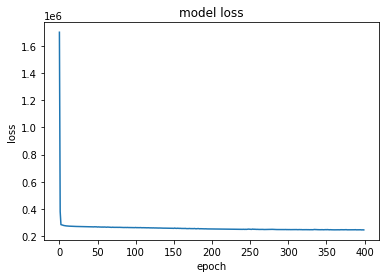

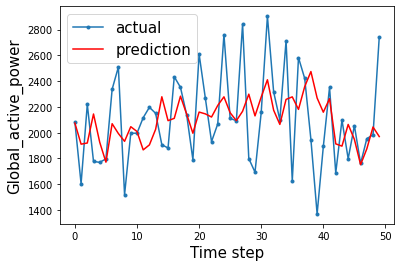

cnn: [400.648] 421.6, 411.1, 368.6, 405.7, 417.6, 321.1, 446.1


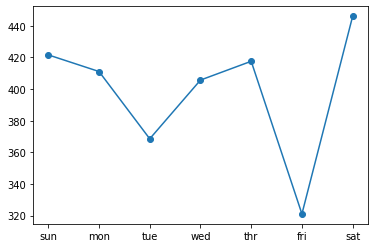

In [0]:
from math import sqrt
from numpy import split
from numpy import array
import numpy as np
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

# split a univariate dataset into train/test sets
def split_dataset(data):
  # split into standard weeks
  train, test = data[1:-328], data[-328:-6]
  # restructure into windows of weekly data
  train = array(split(train, len(train)/7))
  test = array(split(test, len(test)/7))
  return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = sqrt(mse)
    # store
    scores.append(rmse)
  # calculate overall RMSE
  s = 0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s += (actual[row, col] - predicted[row, col])**2
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores

# summarize scores
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end <= len(data):
      x_input = data[in_start:in_end, 0]
      x_input = x_input.reshape((len(x_input), 1))
      X.append(x_input)
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)

def graph(actual, predicted):
  aa=[x for x in range(50)]
  actual=np.ravel(actual)
  predicted=np.ravel(predicted)
  plt.plot(aa, actual[:50], marker='.', label="actual")
  plt.plot(aa, predicted[:50], 'r', label="prediction")
  plt.ylabel('Global_active_power', size=15)
  plt.xlabel('Time step', size=15)  
  plt.legend(fontsize=15)
  plt.show()
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 400, 4
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = Sequential()
  model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam')
  # # model = Sequential()
  # model.add(LSTM(5, input_shape=(n_timesteps,n_features)))
  # model.add(Dropout(0.2))
  # model.add(LSTM(70))
  # model.add(Dropout(0.3))
  #model.add(Dense(n_outputs))
  #model.compile(loss='mse', optimizer='adam')
  print(model.summary())
  # # fit network
  hitory=model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,shuffle=False)
  plt.plot(hitory.history['loss'])
  # plt.plot(hitory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper right')
  plt.show()

  return model


# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, 0]
  # reshape into [1, n_input, 1]
  input_x = input_x.reshape((1, len(input_x), 1))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
  # fit model
  model = build_model(train, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  graph(test[:, :, 0], predictions)

  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores




dataset = read_csv('/content/drive/My Drive/dataset/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# # values = series.values
# import pandas as pd

# x = df.values #returns a numpy array
# print(x.shape)
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# dataset = pd.DataFrame(x_scaled)
train, test = split_dataset(dataset.values)
#evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()